In [1]:
import os
import sys
import torch
import yaml
from tensorboardX import SummaryWriter
import torch.multiprocessing as mp
from argparse import Namespace
from pathlib import Path
import numpy as np

sys.path.append("../../")
from onpolicy.config import get_config
from onpolicy.scripts.train.train_aps import make_train_env


def stack_list_dict_tensor(input):
    output = {}
    for key in input[0].keys():
        output[key] = torch.stack([d[key] for d in input])

    return output


def generate_non_repetitive_randint_tensor(batch, rows, cols, max_val):
    result = torch.empty((batch, rows, cols), dtype=torch.long)

    for i in range(batch):
        for j in range(cols):
            tmp = torch.randperm(max_val)[:rows]
            result[i, :, j] = tmp

    return result


def merge_namespaces(namespace, yaml_namespace):
    for key, value in vars(yaml_namespace).items():
        if isinstance(value, Namespace):
            if hasattr(namespace, key):
                merge_namespaces(getattr(namespace, key), value)
            else:
                setattr(namespace, key, value)
        else:
            setattr(namespace, key, value)


def parse_args(args, parser):
    parser.add_argument("--largest", action='store_true', default=False)
    parser.add_argument("--random", action='store_true', default=False)
    parser.add_argument("--K", type=int, default=1)

    all_args = parser.parse_known_args(args)[0]

    all_args.env_name = "Aps"
    all_args.algorithm_name = "kstrongest"
    all_args.n_rollout_threads = 1
    all_args.seed = 1
    all_args.episode_length = 200
    all_args.num_env_steps = 10000
    all_args.experiment_name = "visualization"
    all_args.largest = True
    
    return all_args


def k_aps(obs, k=1, config=None, largest=True, random=False):
    assert ~config.env_args.use_gnn_embedding
    n_ues = config.env_args.simulation_scenario.number_of_ues
    n_aps = config.env_args.simulation_scenario.number_of_aps

    n_envs = obs.shape[0]
    assert n_ues * n_aps == obs.shape[1]
    if random:
        indices = generate_non_repetitive_randint_tensor(
            batch=n_envs, rows=k, cols=n_ues, max_val=n_aps).to(device=obs.device)
    else:
        channel_mag = torch.tensor(obs[:, :, 0]).view(-1, n_aps, n_ues)
        indices = torch.topk(channel_mag, k, dim=1, largest=largest).indices.to(device=obs.device)
    mask = torch.zeros((n_envs, n_aps, n_ues)).to(device=obs.device)\
        .scatter_(1, indices, 1) \
        .reshape(obs.shape[:2])

    return mask



In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import imageio
import io

def visualize(ue_x, ue_y, ap_x, ap_y, ts):
    clear_output(wait=True)
    plt.figure(figsize=(8, 8))
    plt.scatter(ue_x, ue_y, c='blue', marker='o', label='UE')
    for i in range(len(ue_x[0])):
        plt.text(float(ue_x[0][i]), float(ue_y[0][i]), f'({float(ue_x[0][i]):.2f}, {float(ue_y[0][i]):.2f})', fontsize=9, ha='right')
    plt.scatter(ap_x, ap_y, c='black', marker='X', s=100, label='AP')
    plt.legend()
    plt.title(f'UE Locations at {ts*50} ms, AVG speed: 70 KM/H')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.xlim(-500, 500)
    plt.ylim(-500, 500)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()

    # Highlight a circle with a radius of 1 centered at (0,0)
    circle = plt.Circle((0, 0), 500, alpha=0.2, color='red', fill=True, linestyle='--')
    plt.gca().add_artist(circle)

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    frames.append(imageio.imread(buf))
    buf.close()

    plt.show()


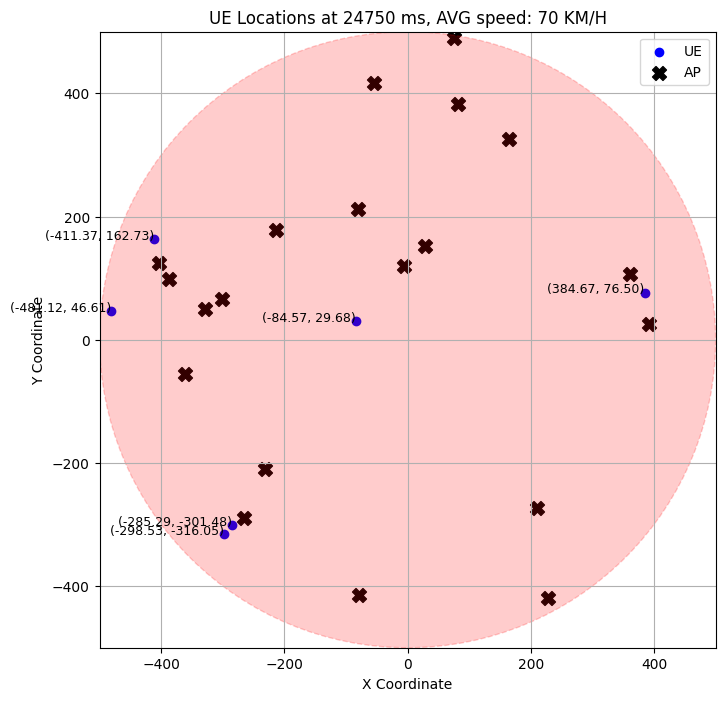

KeyboardInterrupt: 

In [3]:
if __name__ == '__main__':
    if mp.get_start_method(allow_none=True) != 'spawn':
        mp.set_start_method('spawn', force=True)

    parser = get_config()
    all_args = parse_args(sys.argv[1:], parser)

    yaml_path = "/home/mzi/aps-mappo/onpolicy/aps-config.yaml"
    with open(yaml_path, 'r') as file:
        yaml_config = yaml.safe_load(file)
        def yaml_to_namespace(config):
            if isinstance(config, dict):
                return Namespace(**{key: yaml_to_namespace(value) for key, value in config.items()})
            return config
        yaml_namespace = yaml_to_namespace(yaml_config)
        merge_namespaces(all_args, yaml_namespace)

    # reading config params
    log_interval = all_args.log_interval
    n_training_threads = all_args.n_training_threads
    num_env_steps = all_args.num_env_steps
    episode_length = all_args.episode_length
    n_rollout_threads = all_args.n_rollout_threads
    episodes = int(num_env_steps) // episode_length // n_rollout_threads

    # parsing device and type
    torch.set_num_threads(n_training_threads)

    # os.path.split(os.path.dirname(os.path.abspath(__file__)))[0] +
    run_dir = Path("tmp/results") / all_args.env_name / all_args.algorithm_name / all_args.experiment_name
    if not run_dir.exists():
        os.makedirs(str(run_dir))
    if not run_dir.exists():
        curr_run = 'run1'
    else:
        exst_run_nums = [int(str(folder.name).split('run')[1]) for folder in run_dir.iterdir() if
                            str(folder.name).startswith('run')]
        if len(exst_run_nums) == 0:
            curr_run = 'run1'
        else:
            curr_run = 'run%i' % (max(exst_run_nums) + 1)
    run_dir = run_dir / curr_run
    if not run_dir.exists():
        os.makedirs(str(run_dir))

    torch.manual_seed(all_args.seed)
    torch.cuda.manual_seed_all(all_args.seed)
    np.random.seed(all_args.seed)

    log_dir = str(run_dir / 'logs')
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    writer = SummaryWriter(log_dir)
    
    # enabling parallel env execution
    envs = make_train_env(all_args)
    print("envs are generated", flush=True)

    # run
    obs, share_obs, available_actions, _ = envs.reset()
    actions = k_aps(obs, k=all_args.K, largest=all_args.largest, config=all_args, random=all_args.random)
    ts = 0
    frames = []
    for episode in range(episodes):
        print("{}/{} episode for k:{}".format(episode, episodes, all_args.K), flush=True)
        for step in range(episode_length):
            obs, state, reward, done, env_infos, available_actions = envs.step(actions.numpy())
            visualize(ue_x=env_infos[0]['ue_x'].cpu().numpy(), ue_y=env_infos[0]['ue_y'].cpu().numpy(), 
                      ap_x=env_infos[0]['ap_x'].cpu().numpy(), ap_y=env_infos[0]['ap_y'].cpu().numpy(), ts=ts)
            actions = k_aps(obs, k=all_args.K, largest=all_args.largest, config=all_args, random=all_args.random)
            ts += 1


In [4]:
imageio.mimsave("aps_visualization_70kmph.gif", frames, fps=500)